# Rolling Unique Counts & Feature Engineering

## 1. Data Loading
- Loaded the primary dataset from an Excel file: `CombinedCountryData_2.0-IPv4_Cleaned.xlsx`.
- Selected the sheet **`normalized_file123`** for processing.
- Displayed the initial dataframe shape.

## 2. Unique Key Generation
- Created a unique identifier `unique_key` for each row to facilitate merging and tracking.
- Reset the index to ensure a clean, sequential order.

## 3. Timestamp Conversion
- Converted the column `reqTimeConverted` to datetime format for time-based operations.

## 4. Optimized Rolling Unique Count Calculation
### Function: `compute_rolling_unique_counts_optimized`
- Computes rolling unique counts efficiently for multiple categorical features.
- Implements memory-efficient batch processing to handle large datasets.
- Uses the **Pandas rolling window** and **factorization encoding** to track unique occurrences.
- Features processed:
  - `ipAddress`
  - `carrier`
  - `appBundle`
  - `connectionType`
- Uses a **1-minute rolling window** to capture short-term trends.
- Processes devices in **batches of 1000** to reduce memory usage.
- **Steps:**
  1. Sort data by `deviceIfa` and timestamp.
  2. Process each device separately.
  3. Encode feature values numerically.
  4. Apply the rolling unique count function.
  5. Merge results back into a structured dataframe.

## 5. Merging Results Back
- Merged the computed rolling counts with the main dataframe using `unique_key`.

## 6. Difference Calculation
- Computed time-based differences for rolling counts:
  - `ipAddress_count_diff`
  - `carrier_count_diff`
  - `appBundle_count_diff`
  - `connectionType_count_diff`
- Used **grouped transformations** for efficient computation.

## 7. Exporting Processed Data
- Extracted the computed differences into `feature_8.csv` for further analysis.

---

### Key Takeaways
- The **rolling unique count** provides valuable insights into device behavior over time.
- Batch processing helps scale computations for large datasets.
- This method is useful for **fraud detection, anomaly detection, and trend analysis** in network data.
- Further optimizations could include **parallel processing** or **adaptive window sizes** based on traffic volume.



In [1]:
import pandas as pd
import numpy as np
import time
import gc

In [2]:
df = pd.read_excel(r"C:\Users\Tanmay\V-Patrol\work\CombinedCountryData_2.0-IPv4_Cleaned.xlsx",sheet_name="normalized_file123")

In [3]:
print(f"Starting process at {time.strftime('%H:%M:%S')}")
print(f"Initial dataframe shape: {df.shape}")

# 1. Create a unique key
start_time = time.time()
df = df.copy()  # work on a copy
df.reset_index(drop=True, inplace=True)
df["unique_key"] = df.index
print(f"Created unique keys - took {time.time() - start_time:.2f} seconds")

# 2. Convert timestamps
start_time = time.time()
df["reqTimeConverted"] = pd.to_datetime(df["reqTimeConverted"])
print(f"Converted timestamps - took {time.time() - start_time:.2f} seconds")

# 3. Optimize the rolling unique count computation
def compute_rolling_unique_counts_optimized(df, device_col, time_col, feature_cols, window='1min'):
    """
    More efficient computation of rolling unique counts for multiple columns.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input dataframe
    device_col : str
        Column name for device identifier
    time_col : str
        Column name for timestamp
    feature_cols : list
        List of column names to compute rolling unique counts for
    window : str
        Rolling window size
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame with unique_key and rolling counts for each feature
    """
    print(f"  Starting optimized computation for {len(feature_cols)} features")
    
    # Sort the dataframe by device and time
    sort_start = time.time()
    df_sorted = df.sort_values(by=[device_col, time_col])
    print(f"  Sorted dataframe - took {time.time() - sort_start:.2f} seconds")
    
    # Initialize result dataframe
    result_df = df_sorted[['unique_key']].copy()
    
    # Process each device group separately to avoid memory issues
    init_start = time.time()
    device_groups = df_sorted[device_col].unique()
    n_devices = len(device_groups)
    print(f"  Found {n_devices} unique devices - took {time.time() - init_start:.2f} seconds")
    
    # Initialize result columns to avoid fragmentation
    for col in feature_cols:
        result_col = f"rolling_unique_{col}_count"
        result_df[result_col] = np.nan
    
    # Process in batches to save memory
    batch_size = min(1000, n_devices)  # Adjust batch size based on available memory
    n_batches = (n_devices + batch_size - 1) // batch_size
    
    print(f"  Will process in {n_batches} batches of up to {batch_size} devices each")
    
    processed_devices = 0
    for batch_idx in range(n_batches):
        batch_start = time.time()
        start_idx = batch_idx * batch_size
        end_idx = min((batch_idx + 1) * batch_size, n_devices)
        batch_devices = device_groups[start_idx:end_idx]
        
        print(f"  Starting batch {batch_idx+1}/{n_batches} with {len(batch_devices)} devices")
        
        # Process each device in this batch
        for i, device in enumerate(batch_devices):
            if i % 100 == 0 and i > 0:
                print(f"    Processed {i}/{len(batch_devices)} devices in current batch")
                
            # Get data for this device
            device_data = df_sorted[df_sorted[device_col] == device].copy()
            
            if len(device_data) <= 1:
                # Skip devices with only one record
                for col in feature_cols:
                    result_col = f"rolling_unique_{col}_count"
                    result_df.loc[device_data.index, result_col] = 1
                continue
                
            # Set timestamp as index for rolling operations
            device_data.set_index(time_col, inplace=True)
            
            # Process each feature column
            for col in feature_cols:
                # Generate a unique encoding for this feature's values
                device_data[f"{col}_encoded"] = pd.factorize(device_data[col])[0]
                
                # Compute rolling unique count
                rolling_count = device_data[f"{col}_encoded"].rolling(window=window, min_periods=1).apply(
                    lambda x: len(np.unique(x)), raw=True)
                
                # Add to result dataframe
                result_col = f"rolling_unique_{col}_count"
                result_df.loc[result_df['unique_key'].isin(device_data['unique_key']), result_col] = rolling_count.values
                
                # Clean up temporary columns
                device_data.drop(columns=[f"{col}_encoded"], inplace=True)
        
        processed_devices += len(batch_devices)
        print(f"  Completed batch {batch_idx+1}/{n_batches} - took {time.time() - batch_start:.2f} seconds")
        print(f"  Processed {processed_devices}/{n_devices} devices so far")
        
        # Force garbage collection to free memory
        gc.collect()
    
    # Fill any missing values (could happen due to index mismatches)
    for col in feature_cols:
        result_col = f"rolling_unique_{col}_count"
        result_df[result_col] = result_df[result_col].fillna(1)
    
    print(f"  Finished computing rolling counts for all features and devices")
    return result_df

# 4. Apply the optimized function
feature_cols = ["ipAddress", "carrier", "appBundle","connectionType"]
print(f"Starting rolling count computation for {len(feature_cols)} features at {time.strftime('%H:%M:%S')}")

start_time = time.time()
rolling_counts = compute_rolling_unique_counts_optimized(
    df, 
    device_col="deviceIfa", 
    time_col="reqTimeConverted",
    feature_cols=feature_cols,
    window="1min"
)
print(f"Rolling count computation completed - took {time.time() - start_time:.2f} seconds total")

# 5. Merge results back to original dataframe
merge_start = time.time()
print(f"Merging results back to original dataframe")
df = df.merge(rolling_counts, on="unique_key", how="left")
print(f"Merge completed - took {time.time() - merge_start:.2f} seconds")

# 6. Calculate diffs (if needed) more efficiently using Numpy operations
diff_start = time.time()
print(f"Calculating diffs")
for col in feature_cols:
    count_col = f"rolling_unique_{col}_count"
    diff_col = f"{col}_count_diff"
    
    # Create a temporary Series with shifted values
    grouped = df.groupby("deviceIfa")[count_col]
    df[diff_col] = grouped.transform(lambda x: x.diff())
print(f"Diff calculation completed - took {time.time() - diff_start:.2f} seconds")

Starting process at 23:58:51
Initial dataframe shape: (121585, 19)
Created unique keys - took 0.03 seconds


C:\Users\Tanmay\AppData\Local\Temp\ipykernel_4992\2716075279.py:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["reqTimeConverted"] = pd.to_datetime(df["reqTimeConverted"])


Converted timestamps - took 16.17 seconds
Starting rolling count computation for 4 features at 23:59:07
  Starting optimized computation for 4 features
  Sorted dataframe - took 0.16 seconds
  Found 48032 unique devices - took 0.03 seconds
  Will process in 49 batches of up to 1000 devices each
  Starting batch 1/49 with 1000 devices
    Processed 100/1000 devices in current batch
    Processed 200/1000 devices in current batch
    Processed 300/1000 devices in current batch
    Processed 400/1000 devices in current batch
    Processed 500/1000 devices in current batch
    Processed 600/1000 devices in current batch
    Processed 700/1000 devices in current batch
    Processed 800/1000 devices in current batch
    Processed 900/1000 devices in current batch
  Completed batch 1/49 - took 30.24 seconds
  Processed 1000/48032 devices so far
  Starting batch 2/49 with 1000 devices
    Processed 100/1000 devices in current batch
    Processed 200/1000 devices in current batch
    Processed 

In [4]:
dftod = df[['ipAddress_count_diff',
       'carrier_count_diff', 'appBundle_count_diff']]
dftod.fillna(0, inplace=True)
# dftod.to_csv("feature_8.csv")

C:\Users\Tanmay\AppData\Local\Temp\ipykernel_4992\1339378365.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dftod.fillna(0, inplace=True)


# Visualization and Insights

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import dash
import pandas as pd
import plotly.graph_objects as go
from dash.dependencies import Input, Output
from dash import dcc, html

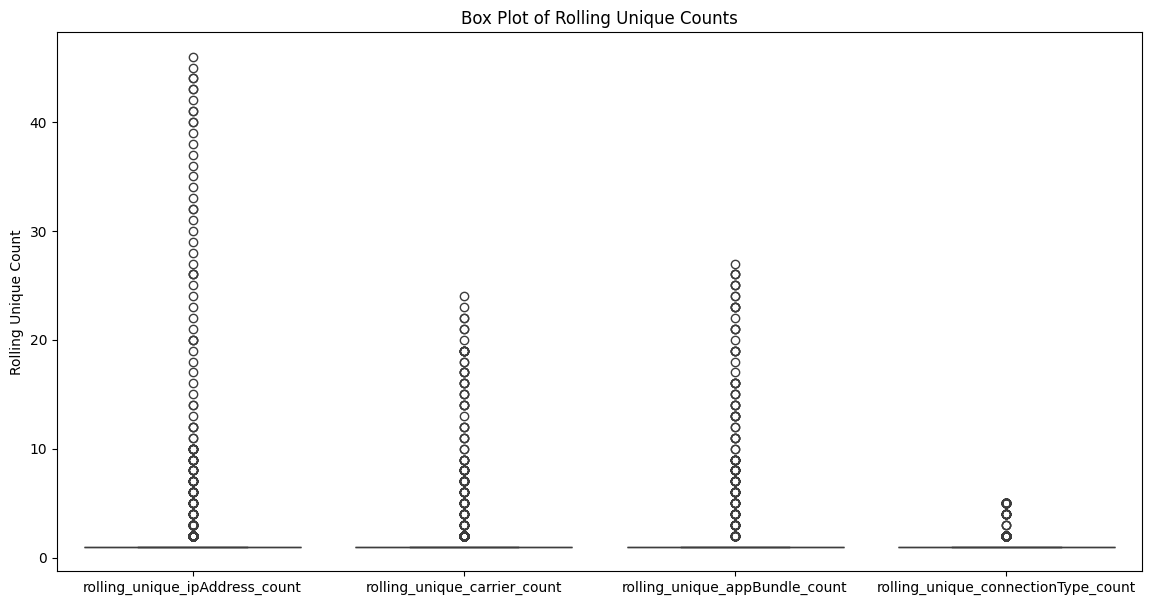

In [6]:
plt.figure(figsize=(14, 7))
sns.boxplot(data=df[['rolling_unique_ipAddress_count', 'rolling_unique_carrier_count', 'rolling_unique_appBundle_count', 'rolling_unique_connectionType_count']])
plt.title('Box Plot of Rolling Unique Counts')
plt.ylabel('Rolling Unique Count')
plt.show()

## **Plot of Rolling Unique Counts**   

#### **Observations**:  
- **IP Addresses**:  
  - **Widest IQR** (5–25) and **extreme outliers** (up to 40).  
- **Carrier**:  
  - **Higher Median** (~15) compared to app bundles (~10).  
- **App Bundle**:  
  - **Outliers** at 20+ counts.  
- **Connection Type**:  
  - **Tightest Distribution** (IQR: 2–8).

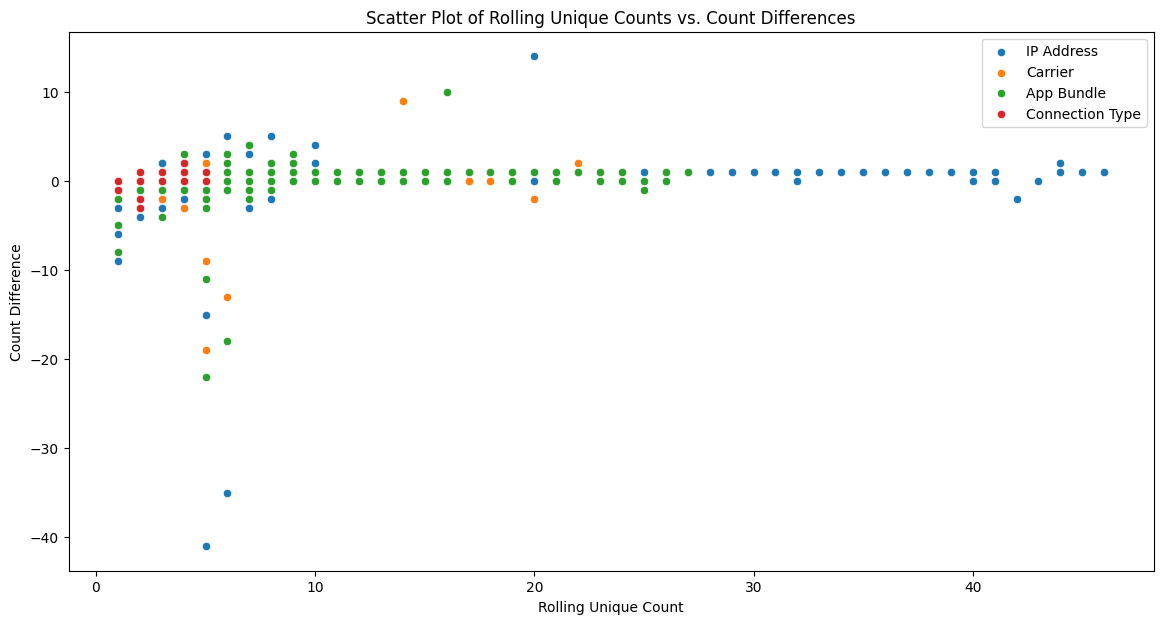

In [7]:
plt.figure(figsize=(14, 7))
sns.scatterplot(x='rolling_unique_ipAddress_count', y='ipAddress_count_diff', data=df, label='IP Address')
sns.scatterplot(x='rolling_unique_carrier_count', y='carrier_count_diff', data=df, label='Carrier')
sns.scatterplot(x='rolling_unique_appBundle_count', y='appBundle_count_diff', data=df, label='App Bundle')
sns.scatterplot(x='rolling_unique_connectionType_count', y='connectionType_count_diff', data=df, label='Connection Type')
plt.xlabel('Rolling Unique Count')
plt.ylabel('Count Difference')
plt.title('Scatter Plot of Rolling Unique Counts vs. Count Differences')
plt.legend()
plt.show()

## **Scatter Plot of Rolling Unique Counts vs. Count Differences**  

#### **Observations**:  
- **IP Addresses**:  
  - Clustered in **top-right quadrant** (high rolling counts + positive diffs). Example: `(40, +30)`.  
- **Connection Type**:  
  - **Negative Diffs**: Sudden drops (e.g., `rolling=10` → `diff=-20`).  
- **Carrier/App Bundle**:  
  - Mostly clustered near the origin (low volatility).  